<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Lab #1: ES models </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 
This is first laboratory task for the course TSA.
The Lab is desinged to impove skills of tuning parameters of ES models and get experience of coding of simple Regression Models.

The Lab should take about 5-6 hours to be completed.

<h1 align="center">Important Info</h1> 
- <span style="font-size: 14pt;"> You must send your solution to the email </span> <span style="color:red; font-size: 12pt;">alexromsput@gmail.com, </span>
- The theme of your message must be <span style="color:red; font-size: 12pt;"> TSA-Erevan-2017-[Your Surname] </span>, for exmaple -- TSA-Erevan-2017-Romanenko,
- You can send ipnb file in attachment or just a link to github. The file in attachment of the letter must be named as <span style="color:red; font-size: 12pt;"> [Surname]-[Group]-Lab1.ipnb</span>, for example -- Romanenko-Evening-Lab1.ipnb,
  
<span style="color:red; font-size: 14pt;"> DEADLINE: 10 June 2017 23:59:59 </span>


<h1 align="center">1. Using ARIMA for wage and electricity comsumption datasets (50%)</h1>
Solve the task for Practice day 2.

<h1 align="center">2. Forecasting of real TS (50%)</h1>
Build the forecast for a dataset  according to the scheme in task 2 (in Practice day 2). You can find the link to dataset that you need to forecast at the sheet 'Lab2' <a href="https://drive.google.com/open?id=11-lzxxR0aeBmEDGEW1GiIaP4X3fyCTHxTg4b0wALpzs">here</a>. 
     


## Setup

In [1]:
# start with this code
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import statsmodels.api as sm
from scipy import stats
import warnings
import time
from copy import deepcopy
import matplotlib.pyplot as plt

%matplotlib inline

/home/gasia/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


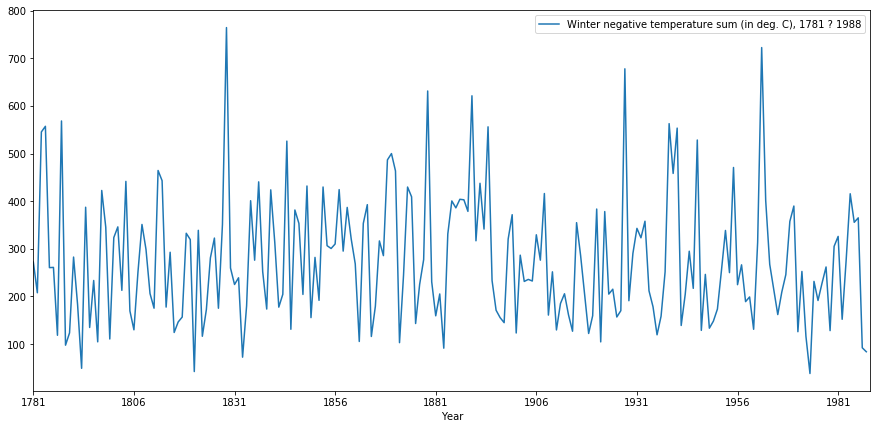

In [2]:
ts = pd.read_csv('./data/winter-negative-temperature-sum-.csv', sep=';', decimal='.', index_col= 'Year', parse_dates=True, dayfirst=True)

# Put your code below
ts.plot(figsize=(15,7))

There is no seasonality, however we will check it later

In [3]:
ts.head()

,"Winter negative temperature sum (in deg. C), 1781 ? 1988"
Year,
1781,272.3
1782,207.8
1783,545.7
1784,557.5
1785,260.6


In [4]:
ts.columns = ['temperature']

In [5]:
ts.tail()

,temperature
Year,
1985,355.8
1986,365.2
1987,92.2
1988,83.9
"Winter negative temperature sum (in deg. C), 1781 ? 1988",NaN


In [6]:
ts = ts[:-1]

In [7]:
ts.tail()

,temperature
Year,
1984,415.8
1985,355.8
1986,365.2
1987,92.2
1988,83.9


In [8]:
print(ts.iloc[0])
print('\n', ts.iloc[-1])

temperature    272.3
Name: 1781, dtype: float64

 temperature    83.9
Name: 1988, dtype: float64


In [9]:
ts = ts.dropna()

In [10]:
from copy import deepcopy
ts_yearly = deepcopy(ts)

In [11]:
ts_yearly.index =  pd.to_datetime(ts_yearly.index)

the beginning of the history is 1781, and the end of the history of TS is 1988

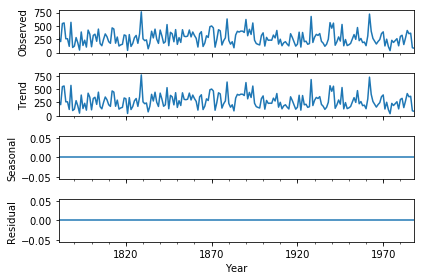

In [12]:
res = sm.tsa.seasonal_decompose(ts_yearly['temperature'].loc['1781':'1988'].resample("AS").sum())
resplot = res.plot()

we don't have any seasanlity, trend is not much clear

In [13]:
ts.index

Index(['1781', '1782', '1783', '1784', '1785', '1786', '1787', '1788', '1789',
       '1790',
       ...
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988'],
      dtype='object', name='Year', length=208)

### Loss Function:

In [14]:
def qualityMACAPE(x,y):
    qlt = ((2*(x-y))/(x+y)).abs().replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

## <h1 align="center"> ARIMA Model

We will follow those steps:
 * 0) Use first 75% of ts
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is
chosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

## <h1 align="center"> -0-

### Train / Test Sets:

In [15]:
# 75% of data goes to train set, 25% goes to test set
train_index = int(ts.shape[0] *75 / 100)
test_index = int(ts.shape[0] * 90 / 100)

In [16]:
ts_train = ts.iloc[:train_index]
ts_test = ts.iloc[:test_index]

## <h1 align="center"> -1-

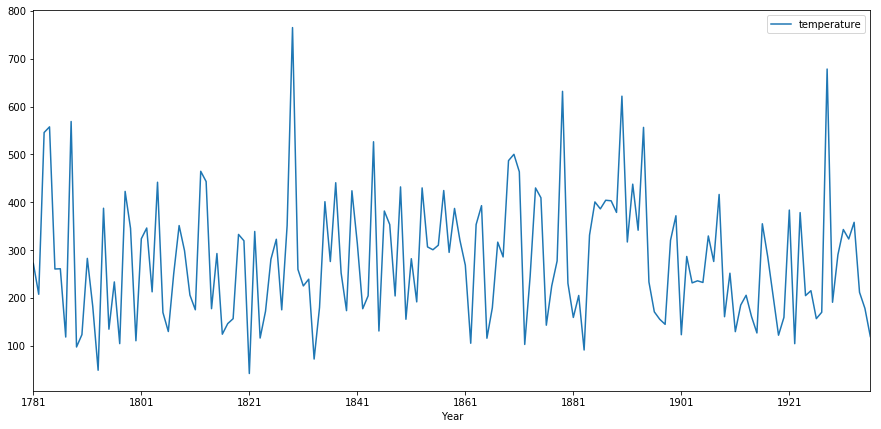

In [17]:
ts_train.plot(figsize = (15,7))

we don't need to preprocess the data 

## <h1 align="center"> -2-

Dispersion is stabilized through transformation.

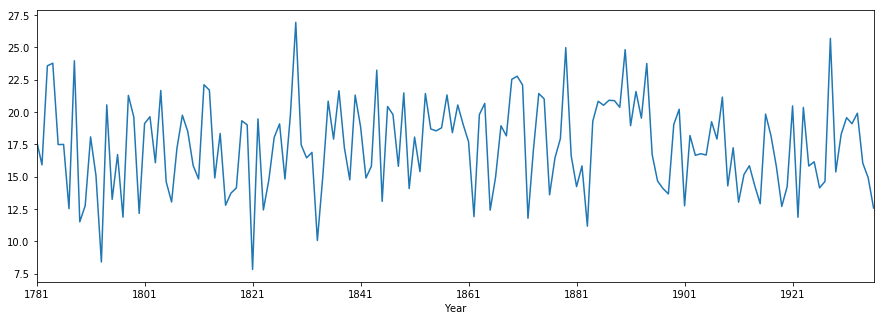

In [18]:
from copy import deepcopy
ts_train_boxcox = deepcopy(ts_train)
ts_train_boxcox['wage_boxcox'], lmbda = stats.boxcox(ts_train)
ts_train_boxcox['wage_boxcox'].plot(figsize=(15,5))

In [19]:
lmbda

array([ 0.35500234])

lmbda=0 is giving a better results

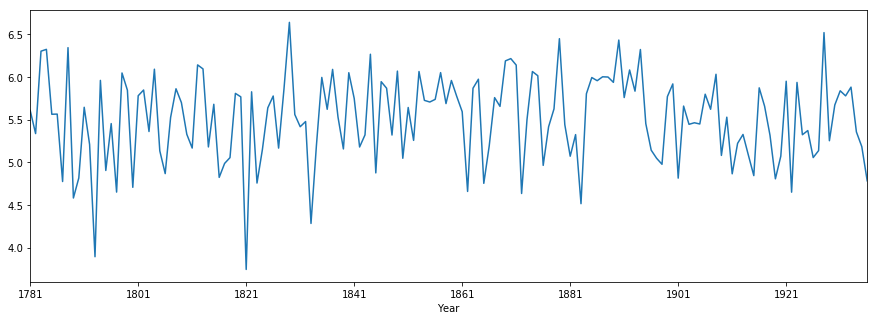

In [20]:
ts_train_boxcox['wage_boxcox'] = stats.boxcox(ts_train, lmbda = 0)
ts_train_boxcox['wage_boxcox'].plot(figsize=(15,5))

## <h1 align="center"> -3-

In [21]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(ts_train_boxcox['wage_boxcox']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.168339, 
pvalue: 0.10 
maximal Lag: 14 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/gasia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


We don't reject the null hypothesis, which means the ts is stationary

In [22]:
ts_train_st = ts_train_boxcox

## <h1 align="center"> -4-

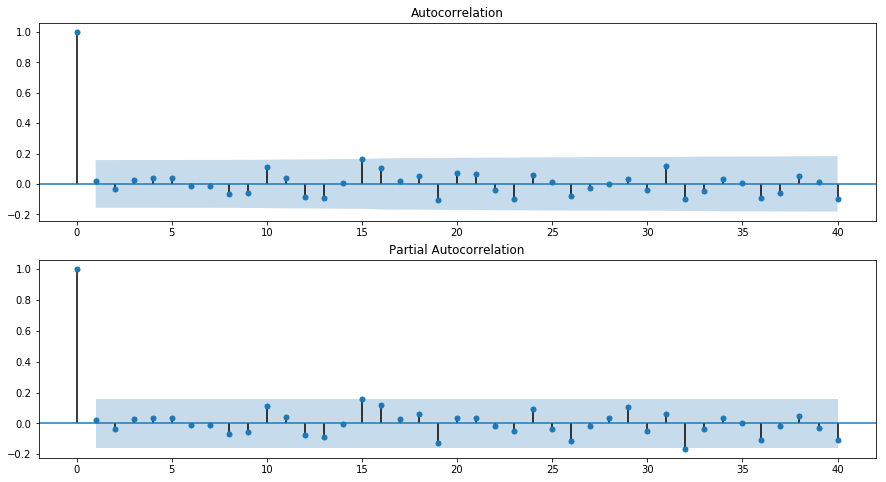

In [23]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_train['temperature'].values.squeeze(), lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_train['temperature'].values.squeeze(), lags=40, ax=ax2)
plt.show()

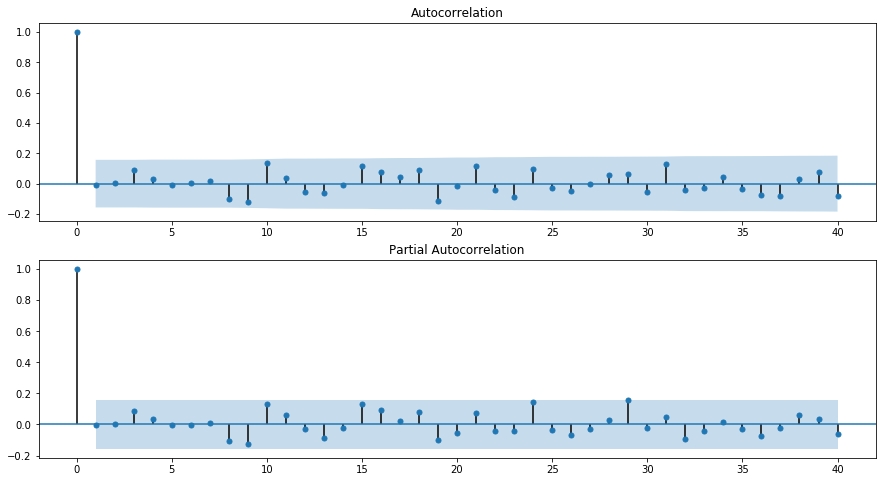

In [24]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_train_st['wage_boxcox'].values.squeeze(), lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_train_st['wage_boxcox'].values.squeeze(), lags=40, ax=ax2)
plt.show()

Possible values: 


Looking to Autocorrelation: 

q = 3, 4, 8, 10

Looking to Partial Autocorrelation: 

p = 3. 5. 8, 10

We need to use ARIMA

## <h1 align="center"> -5-

In [25]:
import itertools

p = [3, 5, 8, 10]
q = [3, 4, 8, 10 ]

pq = [(x[0], x[1]) for x in list(itertools.product(p, q))]
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [26]:
start_time = time.time()

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

loss =[]
loss_min = math.inf
param_min = pq[0]
res_aic = math.inf

for param in pq:
    try:
        arma_mod = sm.tsa.ARMA(ts_train_st['wage_boxcox'], (param[0],param[1]))
        results = arma_mod.fit()
        res_aic = results.aic
        loss.append(results.aic)
        print('ARIMA {} , AIC: {}'.format(param, res_aic))
    except:
        continue
    
    if res_aic < loss_min:
                loss_min = res_aic
                param_min = param
                
print('\nOptimal Parameters:')
print('ARIMA{} - AIC:{}'.format(param_min, loss_min))

print("\n----- %f seconds -----" % (time.time() - start_time))

ARIMA (3, 10) , AIC: 252.01445165753216
ARIMA (5, 3) , AIC: 254.39957995509948
ARIMA (5, 4) , AIC: 249.46646002370886
ARIMA (8, 3) , AIC: nan
ARIMA (8, 4) , AIC: nan
ARIMA (10, 3) , AIC: 256.42299302508894
ARIMA (10, 4) , AIC: 258.766602370347
ARIMA (10, 8) , AIC: 254.81888742119244

Optimal Parameters:
ARIMA(5, 4) - AIC:249.46646002370886

----- 24.875874 seconds -----


In [27]:
# Optimal Params
a = pq[5]
arma_mod = sm.tsa.ARMA(ts_train['temperature'], (a[0], a[1]))
fit_model = arma_mod.fit()

## <h1 align="center"> -6-

### Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested:

In [28]:
# Darbin_Watson statistic
# test autocorrelation
sm.stats.durbin_watson(fit_model.resid.values)

2.0007205499081113

value is near 2, means that there is no autocorrelation in the sample

In [29]:
stat = stats.wilcoxon(fit_model.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 5369.000000
pvalue: 0.18


In [30]:
# Normal test
resid = fit_model.resid
stats.normaltest(resid)

NormaltestResult(statistic=12.705266656900074, pvalue=0.0017421534283575957)

#### The following are satisfied: 

* **Unbiasedness**: equality of the average value to zero (Wilcoxn)
* **Non-autocorrelation**: absence of the unacounted dependency on previous observations (Darbin_Watson)
* **Stationarity**: absence of dependency on time 
* **Normality**: Normal test

## <h1 align="center"> -7-

In [31]:
# using optimal Params
a = pq[5]
arma_mod = sm.tsa.ARMA(ts_train['temperature'], (a[0], a[1]))
fit_model = arma_mod.fit()

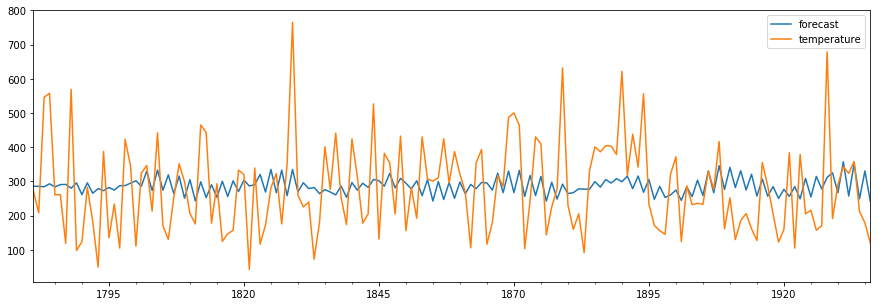

In [32]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = fit_model.plot_predict( ax=ax)

                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                  156
Model:                     ARMA(5, 4)   Log Likelihood                -982.030
Method:                       css-mle   S.D. of innovations            129.038
Date:                Wed, 14 Jun 2017   AIC                           1986.060
Time:                        03:07:23   BIC                           2019.608
Sample:                    01-01-1781   HQIC                          1999.686
                         - 01-01-1936                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               285.6211     10.356     27.580      0.000     265.323     305.919
ar.L1.temperature    -0.0144      0.085     -0.169      0.866      -0.181       0.153
ar.L2.temperature     1.

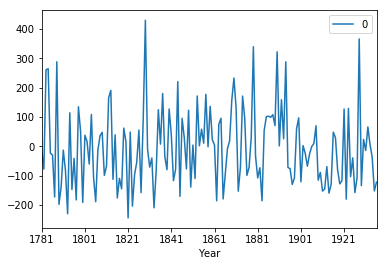

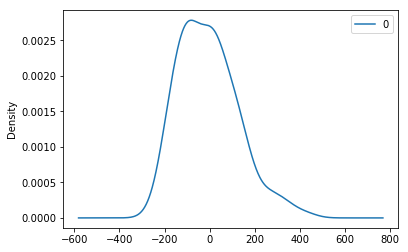

                0
count  156.000000
mean    -6.248431
std    131.531243
min   -243.944038
25%   -107.626902
50%    -13.390472
75%     70.586202
max    430.258817


In [33]:
print(fit_model.summary())

# plot residual errors
residuals = pd.DataFrame(fit_model.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [34]:
frc_arma =fit_model.predict( dynamic=False)

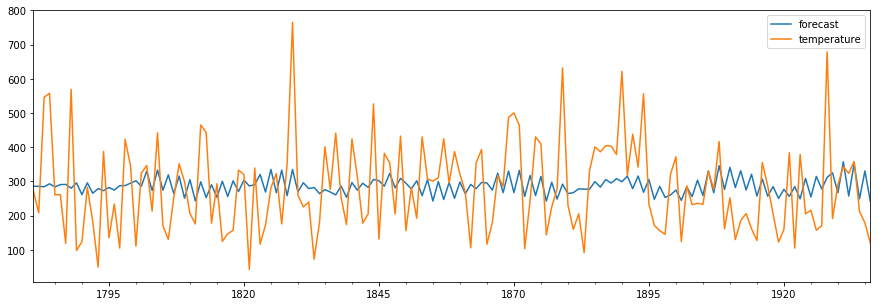

In [35]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = fit_model.plot_predict( ax=ax)

In [36]:
ts_train.tail(2)

,temperature
Year,
1935,178.3
1936,119.5


In [37]:
ts.tail()

,temperature
Year,
1984,415.8
1985,355.8
1986,365.2
1987,92.2
1988,83.9


In [38]:
1988 - 1936

52

#### Forecast of Future Period

In [39]:
frc_arma = fit_model.forecast(steps=52)
frc_arma[0]

array([ 311.50934935,  246.65411941,  284.71691752,  251.21587669,
        270.78225389,  262.19754035,  266.12809299,  278.88098793,
        269.58150578,  297.96562196,  277.53410964,  314.81826046,
        285.32998919,  325.02876296,  288.96542677,  325.94742333,
        286.49716988,  317.65105693,  278.67311461,  302.98446847,
        268.57666985,  286.65033292,  260.42543774,  273.65728107,
        257.9628321 ,  267.66380289,  263.0228581 ,  269.79375876,
        274.78394942,  278.33426789,  289.98082632,  289.41685686,
        304.0016229 ,  298.43751426,  312.48220214,  301.71262938,
        312.83225267,  297.78690192,  305.15105311,  287.93448376,
        292.20623801,  275.68129975,  278.48006356,  265.52313907,
        268.61725794,  261.29813165,  265.81994535,  264.79337498,
        270.75367399,  275.0812372 ,  281.34785938,  288.8213948 ])

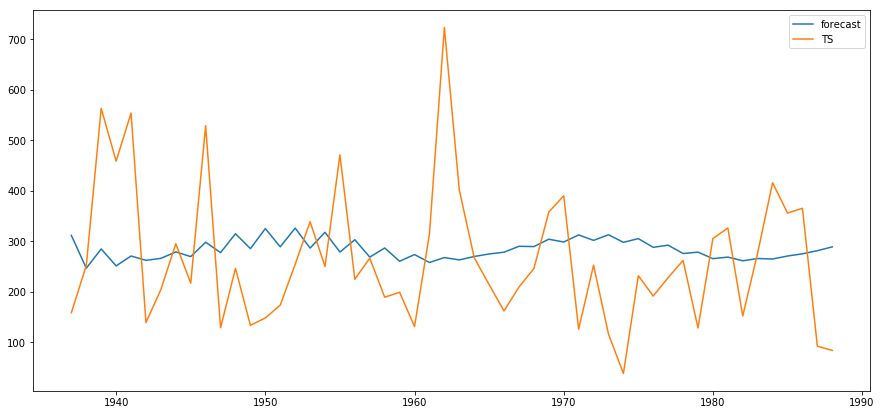

In [40]:
plt.figure(figsize = (15, 7))
plt.plot(ts.index[-52:], frc_arma[0], label = 'forecast')
plt.plot(ts[-52:], label = 'TS')
plt.legend()
plt.show()

It is not doing very well